<img src="https://github.com/aniacharya/MachineLearning/blob/master/images/DXC.png?raw=true" width="240" height="360" />



# AGENT CHURN ANALYSIS using Auto-ML TPOT tool

In [0]:
# Import Packages
import numpy as np
import pandas as pd
import pyodbc

# Get Current time
import datetime 

# For Graphics
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# For splitting data into test and train subsets
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

# For logistic regression
from sklearn.linear_model import LogisticRegression

# For saving the model
from sklearn.externals import joblib 

# For Confusion Matrix
from sklearn import metrics

# For ROC Curve
from sklearn.metrics import roc_auc_score, roc_curve, f1_score

# For Normalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# For Feature Selection
from sklearn.feature_selection import chi2, SelectKBest

# Settings to view all columns and rows
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

#to ignore the warning messages from being printed
import warnings
warnings.filterwarnings('ignore')

In [12]:
df_orig = pd.read_csv('agent_churn.csv')
df_orig.head()

Agent Number  Date_of_Appointment  Date_of_Termination  Commission Class  \
0      50001187             20150526                  NaN                 3   
1      50002503             20151214                  NaN                 3   
2      50004847             20200101                  NaN                 3   
3      50040992             20230104                  NaN                 3   
4      50041143             20230101                  NaN                 2   

  Pay Method  Pay Frequency Agent Type  Agent Branch Code  \
0         DC             12         AM                 10   
1         CQ             12         AG                 10   
2         CQ             12         BR                 10   
3         CQ             12         AG                 10   
4         CQ             12         AM                 10   

   Agent Reporting Level  Agent Date of Birth Agent Gender  \
0                      1           19910507.0            M   
1                      1           19830404.0            M   
2                      1           19800101.0            M   
3                      1           19750101.0            M   
4                      1           19880101.0            M   

   Number_of_Policies  Number_of_Claims  Total_Claim_Amount  \
0                   5                 0                 0.0   
1                   4                 0                 0.0   
2                   0                 0                 0.0   
3                   1                 0                 0.0   
4                   0                 0                 0.0   

   Total_Payment_Amount  Total_Commission_Amount  Churn  
0                   0.0                      0.0      0  
1                   0.0                      0.0      0  
2                   0.0                      0.0      0  
3                   0.0                      0.0      0  
4                   0.0                      0.0      0

# Data treatment

In [0]:
df_work = df_orig.copy()

In [0]:
# Separate features into categorical and numerical category
cat_vars = ['Commission Class','Pay Method','Pay Frequency','Agent Type','Agent Branch Code',
            'Agent Reporting Level','Agent Gender']

num_vars = ['Number_of_Policies', 'Number_of_Claims', 'Total_Claim_Amount','Total_Payment_Amount','Total_Commission_Amount']

date_vars = ['Date_of_Appointment', 'Date_of_Termination', 'Agent Date of Birth' ]

In [0]:
# Convert date columns

for var in date_vars:
    #df_work[var] = df_work[var].astype('category')
    #df_work[var] = datetime.datetime.strptime(var, '%Y-%m-%d')
    df_work[var]=pd.to_datetime(df_work[var].astype(str), format='%Y%m%d')

In [0]:
# Convert to 'category' object type
for var in cat_vars:
    df_work[var] = df_work[var].astype('category')

In [0]:
# Create Dummy Variables for categorical variables
for var in cat_vars:
    cat_list = 'var'+'_'+var
    cat_list = pd.get_dummies(df_work[var], prefix=var)
    dummy_data = df_work.join(cat_list)
    df_work = dummy_data

In [18]:
df_work.shape

(3631, 42)

In [0]:
# Remove original columns for which dummy variables have been created
vars_remove = ['Commission Class','Pay Method','Pay Frequency','Agent Type','Agent Branch Code',
            'Agent Reporting Level','Agent Gender']

for var in vars_remove:
    df_work=df_work.drop(var, axis=1)

In [0]:
# Normalize numerical columns
scaler = MinMaxScaler()
df_work['Number_of_Policies'] = scaler.fit_transform(df_work['Number_of_Policies'].values.reshape(-1,1))
df_work['Number_of_Claims'] = scaler.fit_transform(df_work['Number_of_Claims'].values.reshape(-1,1))
df_work['Total_Claim_Amount'] = scaler.fit_transform(df_work['Total_Claim_Amount'].values.reshape(-1,1))
df_work['Total_Payment_Amount'] = scaler.fit_transform(df_work['Total_Payment_Amount'].values.reshape(-1,1))
df_work['Total_Commission_Amount'] = scaler.fit_transform(df_work['Total_Commission_Amount'].values.reshape(-1,1))

# Feature Engineering

In [0]:
# Get current date
current_time = datetime.datetime.now() 

In [0]:
# Create a new column 'Age' on the basis of date of birth of agent
df_work['age'] = current_time - df_work['Agent Date of Birth']

In [0]:
# Create a new column named 'service period' on the basis of difference between Agent Date of Registration and Termination.
# In case date of Termination is null we will replace it with current date and compute

service_period=[]

for Date_of_Termination,Date_of_Appointment in zip(df_work.iloc[:,2], df_work.iloc[:,1]):
    if Date_of_Termination is pd.NaT:
        service_period.append(abs(current_time-Date_of_Appointment))
    else:
        service_period.append(abs(Date_of_Termination-Date_of_Appointment))
    #print(Date_of_Termination)
    #print(Date_of_Appointment)


In [0]:
# Append the new column to dataframe
df_work['Service_Period']=service_period

# Remove the orginal columns
df_work=df_work.drop('Date_of_Appointment', axis=1)
df_work=df_work.drop('Date_of_Termination', axis=1)
df_work=df_work.drop('Agent Date of Birth', axis=1)

# Remove Agent Number since it is not critical for prediction
df_work=df_work.drop('Agent Number', axis=1)

In [25]:
# Check contents once
df_work.head()

Number_of_Policies  Number_of_Claims  Total_Claim_Amount  \
0            0.004476               0.0                 0.0   
1            0.003581               0.0                 0.0   
2            0.000000               0.0                 0.0   
3            0.000895               0.0                 0.0   
4            0.000000               0.0                 0.0   

   Total_Payment_Amount  Total_Commission_Amount  Churn  Commission Class_1  \
0                   0.0                      0.0      0                   0   
1                   0.0                      0.0      0                   0   
2                   0.0                      0.0      0                   0   
3                   0.0                      0.0      0                   0   
4                   0.0                      0.0      0                   0   

   Commission Class_2  Commission Class_3  Pay Method_CQ  Pay Method_DC  \
0                   0                   1              0              1   
1                   0                   1              1              0   
2                   0                   1              1              0   
3                   0                   1              1              0   
4                   1                   0              1              0   

   Pay Frequency_12  Agent Type_0  Agent Type_7  Agent Type_AG  Agent Type_AM  \
0                 1             0             0              0              1   
1                 1             0             0              1              0   
2                 1             0             0              0              0   
3                 1             0             0              1              0   
4                 1             0             0              0              1   

   Agent Type_AR  Agent Type_BA  Agent Type_BM  Agent Type_BR  Agent Type_CR  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              1              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   Agent Type_DM  Agent Type_GM  Agent Type_SM  Agent Type_UM  \
0              0              0              0              0   
1              0              0              0              0   
2              0              0              0              0   
3              0              0              0              0   
4              0              0              0              0   

   Agent Branch Code_10  Agent Reporting Level_1  Agent Reporting Level_2  \
0                     1                        1                        0   
1                     1                        1                        0   
2                     1                        1                        0   
3                     1                        1                        0   
4                     1                        1                        0   

   Agent Gender_   Agent Gender_F  Agent Gender_M                        age  \
0               0               0               1 10577 days 18:33:04.429953   
1               0               0               1 13532 days 18:33:04.429953   
2               0               0               1 14721 days 18:33:04.429953   
3               0               0               1 16547 days 18:33:04.429953   
4               0               0               1 11799 days 18:33:04.429953   

             Service_Period  
0 1792 days 18:33:04.429953  
1 1590 days 18:33:04.429953  
2  111 days 18:33:04.429953  
3  987 days 05:26:55.570047  
4  984 days 05:26:55.570047

In [0]:
# Normalize the new columns 
scaler = MinMaxScaler()
df_work['age'] = scaler.fit_transform(df_work['age'].values.reshape(-1,1))
df_work['Service_Period'] = scaler.fit_transform(df_work['Service_Period'].values.reshape(-1,1))

In [0]:
# Create separate dataset for feature and target columns
x01 = df_work.drop('Churn', axis=1)
y01 = df_work['Churn']

# To handle class imbalance performing SMOTE

In [28]:
# Perform Test/Train Split
x01_train, x01_test, y01_train, y01_test=train_test_split(x01, y01, test_size=0.3,random_state=11)
x01_train.shape, x01_test.shape, y01_train.shape, y01_test.shape

((2541, 32), (1090, 32), (2541,), (1090,))

In [29]:
# To handle class imbalance performing SMOTE

from imblearn.over_sampling import SMOTE
SMO = SMOTE(random_state=11)

#X4_train, X4_test, Y4_train, Y4_test = train_test_split(X_train,Y_train, test_size=0.20)
x01_train_smo,y01_train_smo = SMO.fit_sample(x01_train, y01_train)
columns = x01_train.columns

x01_train_smo = pd.DataFrame(data = x01_train_smo, columns = columns )
y01_train_smo = pd.DataFrame(data = y01_train_smo, columns = ['Churn'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(x01_train_smo))
print("Number of Churned agents in oversampled data",len(y01_train_smo[y01_train_smo['Churn']== 0 ]))
print("Number of Non Churned agents in oversampled data",len(y01_train_smo[y01_train_smo['Churn']== 1 ]))
print("Proportion of Non Churned agents in oversampled data is ",len(y01_train_smo[y01_train_smo['Churn']== 0])/len(x01_train_smo))
print("Proportion of Churned Agents in oversampled data is ",len(y01_train_smo[y01_train_smo['Churn']== 1 ])/len(x01_train_smo))

length of oversampled data is  5062
Number of Churned agents in oversampled data 2531
Number of Non Churned agents in oversampled data 2531
Proportion of Non Churned agents in oversampled data is  0.5
Proportion of Churned Agents in oversampled data is  0.5


# Model Application

# TPOT

In [31]:
#Import tpot classifier from tpot and initialize it to run for max generation = 5 OR max time = 60 mins
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=5, verbosity=2, max_time_mins=60, n_jobs = -1)
tpot.fit(x01_train_smo, y01_train_smo)
print(tpot.score(x01_test, y01_test))

Generation 1 - Current best internal CV score: 0.9992098763505262
Generation 2 - Current best internal CV score: 0.9992098763505262
Generation 3 - Current best internal CV score: 0.9992098763505262
Generation 4 - Current best internal CV score: 0.9994075048090242
Generation 5 - Current best internal CV score: 0.9996049381752631

Best pipeline: ExtraTreesClassifier(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), bootstrap=False, criterion=gini, max_features=0.8, min_samples_leaf=1, min_samples_split=16, n_estimators=100)
0.9954128440366973


In [32]:
TPOT_Fit_pipeline=tpot.fitted_pipeline_
TPOT_Fit_pipeline

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=False,
                                    interaction_only=False, order='C')),
                ('extratreesclassifier',
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=None, max_features=0.8,
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=16,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=100, n_jobs=None,
                                      oob_score=False, random_state=None,
                                      verbose=

In [33]:
print(tpot.score(x01_test, y01_test))

0.9954128440366973


In [0]:
# Make Predictions
y01_pred_TPOT=TPOT_Fit_pipeline.predict(x01_test)

In [35]:
# Make Confusion Matrix to compare results against actuals
cnf_matrix = metrics.confusion_matrix(y01_test, y01_pred_TPOT)
cnf_matrix  

array([[1084,    4],
       [   1,    1]])

In [36]:
# # Get Accuracy Scores - y01_test vs y01_pred_TPOT
print("Accuracy:",metrics.accuracy_score(y01_test, y01_pred_TPOT))
print("Precision:",metrics.precision_score(y01_test, y01_pred_TPOT))
print("Recall:",metrics.recall_score(y01_test, y01_pred_TPOT))
print("f1 score: ", f1_score(y01_test, y01_pred_TPOT))

Accuracy: 0.9954128440366973
Precision: 0.2
Recall: 0.5
f1 score:  0.28571428571428575


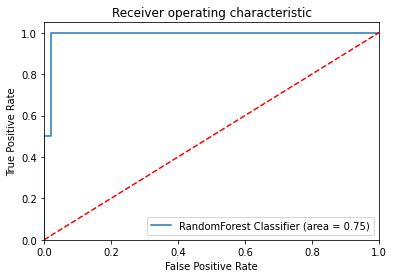

In [37]:
# Print ROC AUC Curve 
 
TPOT_roc_auc = roc_auc_score(y01_test, TPOT_Fit_pipeline.predict(x01_test))
fpr, tpr, thresholds = roc_curve(y01_test, TPOT_Fit_pipeline.predict_proba(x01_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='RandomForest Classifier (area = %0.2f)' % TPOT_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Save the model as PMML File

In [38]:
# Save the model as a pmml and use to make predictions in a file 

joblib.dump(TPOT_Fit_pipeline, 'LifeAgentChurnModelTPOT.pmml') 

['LifeAgentChurnModelTPOT.pmml']